# Iris Dataset Neural Network Classification

A simple Iris Dataset classifier using PyTorch

**Note**: Still need to play around with batch training

## Import Required Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# PyTorch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualizations
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_STATE = 1

## Iris Dataset Cleaning and Processing

In [3]:
# Read dataset
iris_df = pd.read_csv('data/Iris.csv')

iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Brief EDA
print(iris_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


In [5]:
# Brief EDA
print(f'Shape: {iris_df.shape}\n')
print(f'Null entries:\n{iris_df.isnull().sum()}')

Shape: (150, 6)

Null entries:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


In [6]:
# Remove ID column
iris_df.drop(['Id'], axis=1, inplace=True)

In [7]:
# All unique target variables
iris_df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [8]:
# Perform label encoding for target variables
encoding = {'Iris-setosa': 0,
            'Iris-versicolor': 1, 
            'Iris-virginica': 2}

iris_df['Species'] = iris_df['Species'].map(encoding)

iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Create Training, Validation, and Test Dataset

In [9]:
# Predictor and target variables
X = iris_df.drop(['Species'], axis=1).values
y = iris_df['Species'].values

In [10]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.70, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=RANDOM_STATE)

In [11]:
# Scale predictor variables
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

## Create Dataloader

In [12]:
class Dataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.shape = labels.shape[0]
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.shape

    def __getitem__(self, index):
        sample = self.features[index], self.labels[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs).float(), torch.from_numpy(np.array(targets)).long()

In [13]:
# Generators
batch_size = 9

training_set = Dataset(X_train, y_train, transform=ToTensor())
training_generator = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True, num_workers=0)

validation_set = Dataset(X_val, y_val, transform=ToTensor())
validation_generator = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True, num_workers=0)

## Create Neural Network Model

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_input_size, hidden_output_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_input_size)
        self.hidden_layer1 = nn.Linear(hidden_input_size, hidden_output_size)
        self.output_layer = nn.Linear(hidden_output_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.input_layer(x))
        out = self.relu(self.hidden_layer1(out))
        out = self.output_layer(out)
        return out

In [15]:
# Input_dim = 4 because we have 4 inputs namely sepal_length, sepal_width, petal_length, petal_width
# Output_dim = 3 because we have namely 3 categories setosa, versicolor, and virginica

input_size  = 4
hidden_input_size = 128
hidden_output_size = 64
num_classes = 3

model = NeuralNet(input_size, hidden_input_size, hidden_output_size, num_classes).to(device)
#model = NeuralNet(input_size, hidden_input_size, hidden_output_size, num_classes)

In [16]:
# Creating our optimizer and loss function object
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
num_epochs = 1000

train_losses = np.zeros(num_epochs)
validation_losses = np.zeros(num_epochs)

In [18]:
# Loop over epochs
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_validation_loss = 0
    
    # Training loop
    # here: 45 samples, batch_size = 5, n_iters=45/5=9 -> 9 iterations
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Clear out the gradients for the next step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(local_batch)
        
        loss_train = criterion(outputs, local_labels)
        
        # Calculate gradient
        loss_train.backward()

        # Update the weights
        optimizer.step()
        
        epoch_train_loss += loss_train.item()
    

    # Validation
    with torch.set_grad_enabled(False):
        
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            
            # Forward pass
            outputs = model(local_batch)
            loss_validation = criterion(outputs, local_labels)
    
            epoch_validation_loss += loss_validation.item()
    
    # Store training and validation loss per epoch
    train_losses[epoch] = epoch_train_loss
    validation_losses[epoch] = epoch_validation_loss
    
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_validation_loss:.4f}")

Epoch 50/1000, Train Loss: 0.0015, Test Loss: 0.4761
Epoch 100/1000, Train Loss: 0.0004, Test Loss: 0.5170
Epoch 150/1000, Train Loss: 0.0002, Test Loss: 0.5720
Epoch 200/1000, Train Loss: 0.0001, Test Loss: 0.6312
Epoch 250/1000, Train Loss: 0.0001, Test Loss: 0.6575
Epoch 300/1000, Train Loss: 0.0000, Test Loss: 0.6989
Epoch 350/1000, Train Loss: 0.0000, Test Loss: 0.7403
Epoch 400/1000, Train Loss: 0.0000, Test Loss: 0.7610
Epoch 450/1000, Train Loss: 0.0000, Test Loss: 0.8126
Epoch 500/1000, Train Loss: 0.0000, Test Loss: 0.8557
Epoch 550/1000, Train Loss: 0.0000, Test Loss: 0.8764
Epoch 600/1000, Train Loss: 0.0000, Test Loss: 0.8468
Epoch 650/1000, Train Loss: 0.0000, Test Loss: 0.8731
Epoch 700/1000, Train Loss: 0.0000, Test Loss: 0.8894
Epoch 750/1000, Train Loss: 0.0000, Test Loss: 0.9047
Epoch 800/1000, Train Loss: 0.0000, Test Loss: 0.9217
Epoch 850/1000, Train Loss: 0.0000, Test Loss: 0.9430
Epoch 900/1000, Train Loss: 0.0000, Test Loss: 0.9569
Epoch 950/1000, Train Loss: 0

## Model Performance

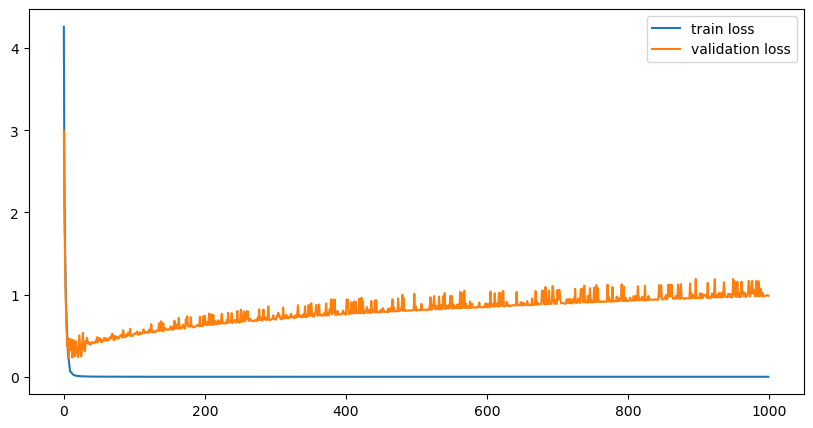

In [19]:
plt.figure(figsize=(10,5))

plt.plot(train_losses, label='train loss')
plt.plot(validation_losses, label='validation loss')
plt.legend()
plt.show()

In [20]:
predictions_train = []
predictions_test =  []

with torch.no_grad():
    predictions_train = model(torch.FloatTensor(X_train).to(device))
    predictions_test = model(torch.FloatTensor(X_test).to(device))

In [21]:
# Get performance accuracy
def get_accuracy(y_predict, y_test):    
    _, predicted = torch.max(y_predict, 1)
    
    count = 0
    for i, j in zip(y_test, predicted):
        count += 1 if i == j else 0
            
    return count/len(predicted)

In [22]:
print(f'Training accuracy: {get_accuracy(predictions_train, y_train)}')
print(f'Test accuracy: {get_accuracy(predictions_test, y_test)}')

Training accuracy: 1.0
Test accuracy: 0.9433962264150944
